# Convolutional neural networks

In this notebook, we'll put together our convolutional layers to implement a 3-layer CNN.  Then, we'll ask you to implement a CNN that can achieve > 65% validation error on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, their layer structure, and their implementation of fast CNN layers.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  


If you have not completed the Spatial BatchNorm Notebook, please see the following description from that notebook:

Please copy and paste your prior implemented code from HW #4 to start this assignment.  If you did not correctly implement the layers in HW #4, you may collaborate with a classmate to use their layer implementations from HW #4.  You may also visit TA or Prof OH to correct your implementation.  

You'll want to copy and paste from HW #4:
    - layers.py for your FC network layers, as well as batchnorm and dropout.
    - layer_utils.py for your combined FC network layers.
    - optim.py for your optimizers.

Be sure to place these in the `nndl/` directory so they're imported correctly.  Note, as announced in class, we will not be releasing our solutions.

In [10]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from nndl.cnn import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from nndl.layers import *
from nndl.conv_layers import *
from utils.fast_layers import *
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Three layer CNN

In this notebook, you will implement a three layer CNN.  The `ThreeLayerConvNet` class is in `nndl/cnn.py`.  You'll need to modify that code for this section, including the initialization, as well as the calculation of the loss and gradients.  You should be able to use the building blocks you have either earlier coded or that we have provided.  Be sure to use the fast layers.

The architecture of this CNN will be:

conv - relu - 2x2 max pool - affine - relu - affine - softmax

We won't use batchnorm yet.  You've also done enough of these to know how to debug; use the cells below.

Note: As we are implementing several layers CNN networks. The gradient error can be expected for the `eval_numerical_gradient()` function. If your `W1 max relative error` and `W2 max relative error` are around or below 0.01, they should be acceptable. Other errors should be less than 1e-5. 

In [12]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 0.00021540464795099533
W2 max relative error: 0.0017648686770178317
W3 max relative error: 0.00010071024924608103
b1 max relative error: 2.948396033351636e-05
b2 max relative error: 4.570476253477182e-07
b3 max relative error: 1.7777958838980442e-09


### Overfit small dataset

To check your CNN implementation, let's overfit a small dataset.

In [13]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 2.280843
(Epoch 0 / 10) train acc: 0.250000; val_acc: 0.153000
(Iteration 2 / 20) loss: 2.909015
(Epoch 1 / 10) train acc: 0.230000; val_acc: 0.153000
(Iteration 3 / 20) loss: 2.574897
(Iteration 4 / 20) loss: 2.216059
(Epoch 2 / 10) train acc: 0.300000; val_acc: 0.143000
(Iteration 5 / 20) loss: 2.280850
(Iteration 6 / 20) loss: 1.618330
(Epoch 3 / 10) train acc: 0.480000; val_acc: 0.177000
(Iteration 7 / 20) loss: 1.550600
(Iteration 8 / 20) loss: 1.533238
(Epoch 4 / 10) train acc: 0.610000; val_acc: 0.176000
(Iteration 9 / 20) loss: 1.319464
(Iteration 10 / 20) loss: 1.092524
(Epoch 5 / 10) train acc: 0.730000; val_acc: 0.176000
(Iteration 11 / 20) loss: 0.952148
(Iteration 12 / 20) loss: 0.823965
(Epoch 6 / 10) train acc: 0.710000; val_acc: 0.178000
(Iteration 13 / 20) loss: 0.894186
(Iteration 14 / 20) loss: 0.654674
(Epoch 7 / 10) train acc: 0.810000; val_acc: 0.208000
(Iteration 15 / 20) loss: 0.812115
(Iteration 16 / 20) loss: 0.287689
(Epoch 8 / 10) tr

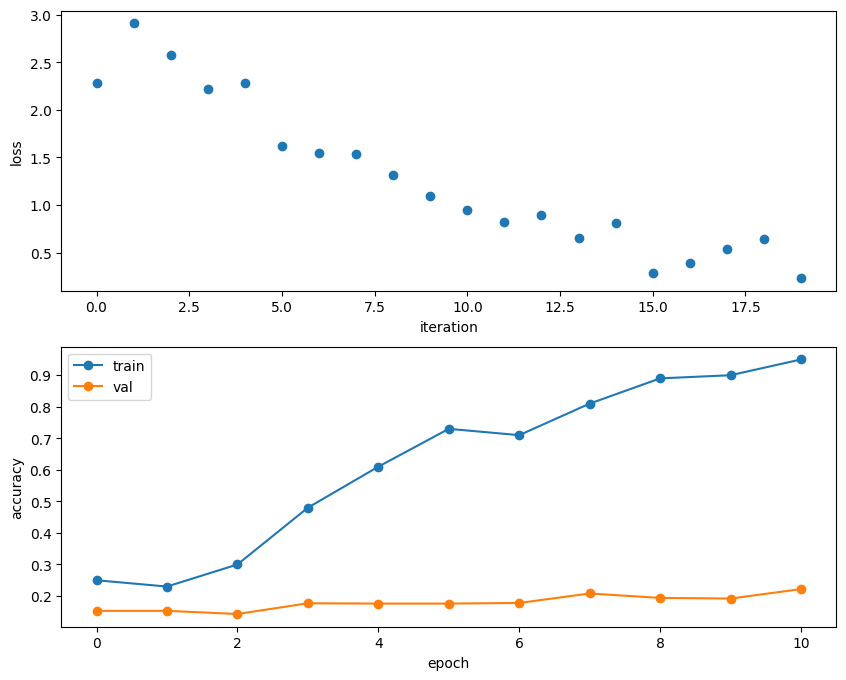

In [14]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the network

Now we train the 3 layer CNN on CIFAR-10 and assess its accuracy.

In [21]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()


(Iteration 1 / 980) loss: 2.304939
(Epoch 0 / 1) train acc: 0.117000; val_acc: 0.128000
(Iteration 21 / 980) loss: 2.183147
(Iteration 41 / 980) loss: 2.142793
(Iteration 61 / 980) loss: 1.891545
(Iteration 81 / 980) loss: 1.915329
(Iteration 101 / 980) loss: 1.781053
(Iteration 121 / 980) loss: 2.304722
(Iteration 141 / 980) loss: 1.830852
(Iteration 161 / 980) loss: 1.454334
(Iteration 181 / 980) loss: 1.887367
(Iteration 201 / 980) loss: 1.832030
(Iteration 221 / 980) loss: 1.751510
(Iteration 241 / 980) loss: 2.039439
(Iteration 261 / 980) loss: 1.837052
(Iteration 281 / 980) loss: 1.705089
(Iteration 301 / 980) loss: 1.652323
(Iteration 321 / 980) loss: 1.613009
(Iteration 341 / 980) loss: 1.644134
(Iteration 361 / 980) loss: 1.528704
(Iteration 381 / 980) loss: 1.608708
(Iteration 401 / 980) loss: 1.872454
(Iteration 421 / 980) loss: 1.678102
(Iteration 441 / 980) loss: 1.621624
(Iteration 461 / 980) loss: 1.637929
(Iteration 481 / 980) loss: 1.488162
(Iteration 501 / 980) loss: 

# Get > 65% validation accuracy on CIFAR-10.

In the last part of the assignment, we'll now ask you to train a CNN to get better than 65% validation accuracy on CIFAR-10.

### Things you should try:
- Filter size: Above we used 7x7; but VGGNet and onwards showed stacks of 3x3 filters are good.  
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: Can a deeper CNN do better?  Consider these architectures:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

In [49]:
model = ThreeLayerConvNet(filter_size=3, num_filters=32, weight_scale=0.001, hidden_dim=500, reg=0.001, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=5, batch_size=200,
                update_rule='adam',
                lr_decay=0.9,
                optim_config={
                  'learning_rate': 3e-4,
                },
                verbose=True, print_every=50)
solver.train()


(Iteration 1 / 1225) loss: 2.305321
(Epoch 0 / 5) train acc: 0.112000; val_acc: 0.119000
(Iteration 51 / 1225) loss: 1.460897
(Iteration 101 / 1225) loss: 1.351147
(Iteration 151 / 1225) loss: 1.155286
(Iteration 201 / 1225) loss: 1.138279
(Epoch 1 / 5) train acc: 0.652000; val_acc: 0.627000
(Iteration 251 / 1225) loss: 0.977941
(Iteration 301 / 1225) loss: 0.949747
(Iteration 351 / 1225) loss: 0.818428
(Iteration 401 / 1225) loss: 0.869972
(Iteration 451 / 1225) loss: 0.824553
(Epoch 2 / 5) train acc: 0.693000; val_acc: 0.658000
(Iteration 501 / 1225) loss: 0.787810
(Iteration 551 / 1225) loss: 0.699099
(Iteration 601 / 1225) loss: 0.720145
(Iteration 651 / 1225) loss: 0.632651
(Iteration 701 / 1225) loss: 0.644911
(Epoch 3 / 5) train acc: 0.783000; val_acc: 0.677000
(Iteration 751 / 1225) loss: 0.711190
(Iteration 801 / 1225) loss: 0.757486
(Iteration 851 / 1225) loss: 0.527403
(Iteration 901 / 1225) loss: 0.601934
(Iteration 951 / 1225) loss: 0.536701
(Epoch 4 / 5) train acc: 0.8180